<a href="https://colab.research.google.com/github/dikshabhati1/song-lyrics-generator/blob/main/song_lyics_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf
 
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
 
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dikshabhati2002","key":"7240b5962cdd3f43c03d2f43468d19e1"}'}

In [3]:
#create a new file and move the kaggle file into it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d neisse/scrapped-lyrics-from-6-genres

 80% 61.0M/75.8M [00:00<00:00, 67.3MB/s]
100% 75.8M/75.8M [00:00<00:00, 111MB/s] 


In [6]:
!unzip -q "/content/scrapped-lyrics-from-6-genres.zip"

In [7]:
df = pd.read_csv('/content/lyrics-data.csv')

In [8]:
# first few rows
df.head()

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH


So we are going to do text generation,we don't need require others column so we will drop it.But I am not going to drop Idiom column as I have to take english songs,so this column is require for subsetting the dataset

In [9]:
# drop
df.drop(['ALink','SName','SLink'],axis=1,inplace=True)

In [10]:
# shape
df.shape

(209522, 2)

In [11]:
# value count
df['Idiom'].value_counts()

ENGLISH           114723
PORTUGUESE         85085
SPANISH             4812
ITALIAN              626
FRENCH               471
GERMAN               314
KINYARWANDA           88
ICELANDIC             47
SWEDISH               27
FINNISH               24
INDONESIAN            17
GALICIAN              12
ESTONIAN              12
HAITIAN_CREOLE         9
IRISH                  9
DANISH                 9
BASQUE                 8
TAGALOG                7
NORWEGIAN              7
CROATIAN               7
CATALAN                6
SUNDANESE              6
DUTCH                  5
SWAHILI                5
MALAY                  4
RUSSIAN                4
SERBIAN                3
SESOTHO                2
CEBUANO                2
MALAGASY               2
NYANJA                 2
ARABIC                 2
TURKISH                2
KURDISH                2
JAPANESE               2
CZECH                  1
HUNGARIAN              1
KOREAN                 1
SLOVENIAN              1
HMONG                  1


Now I want to take only english songs,so I need to subset the dataset accordingly

In [12]:
# take only english songs
df = df[df['Idiom']=='ENGLISH']

I don't have much memory in this google colab.So we can't train the model on whole dataset.So I am going to take first 600 rows.If you have more memory in your local then go ahead and train the model on whole dataset

In [13]:
# take first 700 rows
df = df[:700]

In [45]:
# shape
df.shape

(700, 3)

In [60]:
df.to_csv('final_song_df.csv',index=False)

# Data Visualization

In [16]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df.head()

,Lyric,Idiom,Number_of_words
0,I could feel at the time. There was no way of ...,ENGLISH,145
1,"Take me now, baby, here as I am. Hold me close...",ENGLISH,238
2,These are. These are days you'll remember. Nev...,ENGLISH,172
3,"A lie to say, ""O my mountain has coal veins an...",ENGLISH,263
4,Trudging slowly over wet sand. Back to the ben...,ENGLISH,118


In [17]:
# statistical info
df['Number_of_words'].describe()

count    700.000000
mean     251.608571
std       99.355784
min        9.000000
25%      178.000000
50%      246.000000
75%      309.000000
max      656.000000
Name: Number_of_words, dtype: float64

So from above we can see the max length is 656 and average song lyrics words length is 249

**Frequency distribution of number of words**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

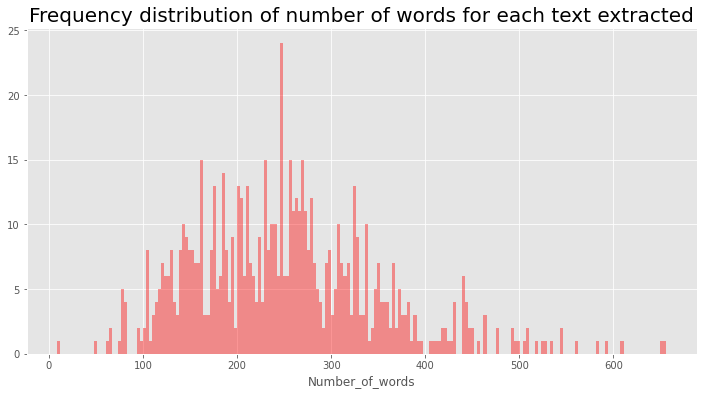

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

# Data Preprocessing

First of all we are going to do tokenization then we will generate sequence of n-grams.After that we will going to do padding.Padding is required because all the sentences are of different length so we need to make them of same length.We will going to do this by adding 0 in the beginning of the text with the help of pad_sequences function of keras

In [19]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
tokenized_sentences[0]

[2,
 75,
 67,
 81,
 1,
 32,
 74,
 53,
 41,
 60,
 10,
 565,
 1029,
 1080,
 9,
 1,
 154,
 92,
 35,
 52,
 76,
 312,
 1465,
 62,
 313,
 62,
 1,
 681,
 3607,
 1907,
 122,
 1,
 404,
 21,
 1,
 682,
 181,
 41,
 60,
 10,
 755,
 103,
 149,
 16,
 3,
 23,
 80,
 131,
 103,
 149,
 16,
 85,
 7,
 42,
 135,
 103,
 149,
 16,
 3,
 23,
 80,
 131,
 8,
 53,
 517,
 22,
 6,
 185,
 74,
 53,
 41,
 60,
 10,
 565,
 33,
 6,
 332,
 9,
 1,
 154,
 92,
 35,
 52,
 76,
 142,
 157,
 41,
 263,
 9,
 1,
 79,
 258,
 14,
 1907,
 122,
 1,
 404,
 21,
 1,
 682,
 181,
 41,
 60,
 10,
 755,
 103,
 149,
 16,
 3,
 23,
 80,
 131,
 103,
 149,
 16,
 85,
 7,
 42,
 135,
 103,
 149,
 16,
 3,
 23,
 80,
 131,
 103,
 149,
 16,
 3,
 23,
 80,
 131,
 103,
 149,
 16,
 85,
 7,
 42,
 135,
 103,
 149,
 16,
 80,
 131]

In [20]:
total_words

8556

In [21]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [22]:
max_sequence_len

656

In [23]:
input_sequences[:10]

array([[ 0,  0,  0, ...,  0,  2, 75],
       [ 0,  0,  0, ...,  2, 75, 67],
       [ 0,  0,  0, ..., 75, 67, 81],
       ...,
       [ 0,  0,  0, ..., 74, 53, 41],
       [ 0,  0,  0, ..., 53, 41, 60],
       [ 0,  0,  0, ..., 41, 60, 10]], dtype=int32)

For the model, we need to create predictors and label. We are going to create N-grams sequence as predictors and the next word of the N-gram as label.

In [24]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Model

We will not going to create RNN model due to its vanishing gradient problem instead of that we will going to create LSTM model.LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively.

In [25]:
# create model
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))

# earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 655, 40)           342240    
_________________________________________________________________
bidirectional (Bidirectional (None, 500)               582000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 8556)              4286556   
Total params: 5,210,796
Trainable params: 5,210,796
Non-trainable params: 0
_________________________________________________________________


In [27]:
checkpoint_path = "lstm-model.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# train
history = model.fit(X,y,batch_size = 256 , epochs = 60 ,callbacks=[cp_callback])

Epoch 1/60
687/687 [==============================] - 241s 346ms/step - loss: 6.6271 - accuracy: 0.0392

Epoch 00001: saving model to lstm-model.ckpt
Epoch 2/60
687/687 [==============================] - 239s 348ms/step - loss: 5.8887 - accuracy: 0.0663

Epoch 00002: saving model to lstm-model.ckpt
Epoch 3/60
687/687 [==============================] - 239s 348ms/step - loss: 5.5225 - accuracy: 0.0907

Epoch 00003: saving model to lstm-model.ckpt
Epoch 4/60
687/687 [==============================] - 238s 347ms/step - loss: 5.1160 - accuracy: 0.1198

Epoch 00004: saving model to lstm-model.ckpt
Epoch 5/60
687/687 [==============================] - 238s 346ms/step - loss: 4.7285 - accuracy: 0.1508

Epoch 00005: saving model to lstm-model.ckpt
Epoch 6/60
687/687 [==============================] - 237s 345ms/step - loss: 4.3935 - accuracy: 0.1852

Epoch 00006: saving model to lstm-model.ckpt
Epoch 7/60
687/687 [==============================] - 237s 345ms/step - loss: 4.1058 - accuracy: 0.2

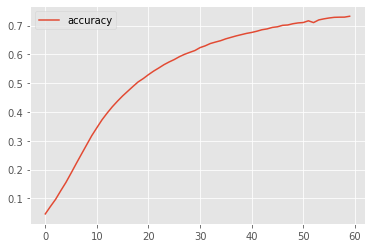

In [30]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

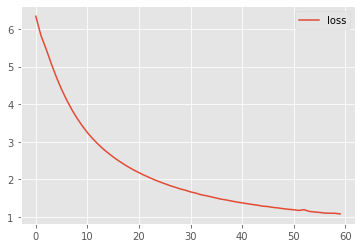

In [31]:
# plot the accuracy
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

# Load Model

In [32]:
# load weights
model.load_weights(checkpoint_path)

# Generate new song lyrics

Now our model is ready.So lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.

In [33]:
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

Our function is ready so are you ready to generate your own lyrics

In [34]:
complete_this_song("the sky is blue", 40)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"the sky is blue heaven he shows the days in a dying of her face she were the best of me i looked up and i don't know to be the one thing i didn't have to even when i don't have to make"

In [35]:
complete_this_song("This is the beginning", 140)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"This is the beginning of the end of the end of her place that were her would be seen in the clouds big wrote to go down i go awake i can't survive the world i've silence it was the last time she could come had to come and i can see him i don't mean the one to call it through the first one i'm chill me on the radio i'm gone i'm far down my heart is the same old eyes i thank you the things that i am i'm gonna come on and i can't wait to get a right here i've been through the way i wanted to be so i can get through a while i'm gonna come on your head and i'm trying to be all the time to shine the one to anyone forget the day just"

In [36]:
complete_this_song("I am missing you", 80)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"I am missing you i will not understand i get ahead the day would bring my tears lay lying high now now i've been there to all i know it's all that i’d been now and i'm trying to be but it's not the person that i knew back then you try to find your way away i could never go then i guess i should have this whole life i've become this life i can't turn to all that i was a long"

In [37]:
complete_this_song("Tell me something new", 200)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"Tell me something new will all this pain be haunting to be too one to see there's a life there's no one to hide the shame like a trip where the rest of your life that everything is part of all this is all my soul before my friend the city is the moon i knew that i was a place or will i do i'm a race that we had to be alone but love the darkness comes thinking that i had a place to help me down if i'm on your own way to reach the past to crack my heart with the way i feel now the weather and sweet i'm tired of the world last feelings i feel with you so it's not a part of my life i'm insane and i'm scared to be coming now i'm so scared i'm not the easiest route and we go alone it's the one to the life i tell you will take this with your life now i'm afraid now i know that i could not give my hand in my own i'm my hand with my daisy i still seen the world and you will never be your life but i"

# Streamlit

In [38]:
!pip install streamlit

In [39]:
!pip install pyngrok

In [40]:
from pyngrok import ngrok

In [64]:
%%writefile app.py
## Import libs

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import string
import numpy as np
from tensorflow.keras.models import  Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,LSTM ,Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
import warnings
warnings.filterwarnings('ignore')

import streamlit as st
import pickle
import time
import pandas as pd

import base64



## Read file
def main():
    st.markdown("<h1 style='text-align: center; color: red;'>Song Lyrics Generator</h1>", unsafe_allow_html=True)

    
    # Tokenization
    df = pd.read_csv("/content/final_song_df.csv")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

    
    # create model
    model = Sequential()
    model.add(Embedding(8556, 40, input_length=656-1))
    model.add(Bidirectional(LSTM(250)))
    model.add(Dropout(0.1))
    model.add(Dense(8556, activation='softmax'))
   


    ## Load model using checkpoint
    checkpoint_path = "lstm-model.ckpt"
    model.load_weights(checkpoint_path)


    ## predict func
    def complete_this_song(seed_text, next_words):
        for _ in range(next_words):
            # tokenizer = Tokenizer()
            token_list = tokenizer.texts_to_sequences([seed_text])[0]
            token_list = pad_sequences([token_list], maxlen=656-1, padding='pre')
            predicted = model.predict_classes(token_list, verbose=0)
        
            output_word = ""
            for word, index in tokenizer.word_index.items():
                if index == predicted:
                    output_word = word
                    break
            seed_text += " " + output_word
        return seed_text

    
    seed_text = st.text_area('Start your song lyrics:', '', height=200, max_chars=1000)
    next_words = slider = st.slider('Max text length (in characters)', 5, 1000)
    button = st.button('Generate')


    if button:
        st.markdown(f"""<h3 style='text-align: center; color: white;background :rgba(153, 184, 20, 0.9);'> {complete_this_song(seed_text, next_words)}</h3>""", unsafe_allow_html=True)
 

if __name__ == "__main__":
    main()

Overwriting app.py


In [65]:
public_url = ngrok.connect(port=80)

In [ ]:
print(public_url)
!streamlit run --server.port 80 app.py >/dev/null